In [1]:
import torch
print(torch.cuda.device_count())
from unsloth import FastLanguageModel

from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling, BitsAndBytesConfig
import transformers
from datasets import load_dataset, Dataset
import pprint
import json
from pathlib import Path
import os
import numpy as np
import time
import re
import pandas as pd

2
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:

device = f"cuda"
from huggingface_hub import hf_hub_download
import os


if torch.cuda.get_device_capability()[0] >= 8:
    attn_implementation = "flash_attention_2"
    torch_dtype = torch.bfloat16
else:
    attn_implementation = "eager"
    torch_dtype = torch.float16
# attn_implementation = "eager"
print(f"Using {attn_implementation} for attention computation.")

# ------------------------------------------------------------

model_id = 'sh2orc/Llama-3.1-Korean-8B-Instruct'
# model_id = 'Bllossom/llama-3.2-Korean-Bllossom-3B'
# model_id = 'Saxo/Linkbricks-Horizon-AI-Korean-Gemma-2-sft-dpo-27B'
# model_id = 'Bllossom/llama-3-Korean-Bllossom-70B'

model_dir = f"/model/{model_id.replace('/', '-')}"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_id,
    # max_seq_length = max_seq_length,
    dtype = torch_dtype,
    load_in_4bit = False,
    load_in_8bit = False,
    # quantization_config=BitsAndBytesConfig(
    #     load_in_4bit=True,
    #     bnb_4bit_use_double_quant=True,
    #     bnb_4bit_quant_type="nf4",
    #     bnb_4bit_compute_dtype=torch_dtype
    #     # load_in_8bit=True,
    #     # llm_int8_enable_fp32_cpu_offload=False if not "27B" in model_id else True,
    # ),
    # device_map=device,
    cache_dir=f"{model_dir}/cache",
    attn_implementation=attn_implementation,
    local_files_only=True
)
FastLanguageModel.for_inference(model)
tokenizer.padding_side = "left"

Using flash_attention_2 for attention computation.


==((====))==  Unsloth 2025.1.8: Fast Llama patching. Transformers: 4.48.2.
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.689 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

sh2orc/Llama-3.1-Korean-8B-Instruct does not have a padding token! Will use pad_token = <|finetune_right_pad_id|>.


In [3]:
from pathlib import Path  # Import Path from pathlib
import json
dataset_name = "v7-250309-reduceinputanddatefunctioncall"
dataset_dir = Path(f"/workspace/finetuning/dataset/{dataset_name}")

metadatas = {}
for directory in dataset_dir.iterdir():
    if directory.is_dir() and "scenario" in directory.name:
        with open(f"{directory}/metadata.json", "r", encoding="utf-8") as f:
            metadatas[directory.name] = json.loads(f.read())

print(metadatas)
        

{'scenario1': {'site_name': 'YongDongIllHighSchool', 'user_name': '홍길동', 'user_role': 'customer', 'idu_name': '01_IB5', 'idu_mapping': {'01_IB5': ['우리반'], '01_IB7': ['옆반'], '02_I81': ['앞반']}, 'modality_mapping': {'roomtemp': ['실내온도'], 'settemp': ['설정온도'], 'oper': ['전원']}, 'current_datetime': '2022-09-30 12:00:00'}}


In [13]:
file_name = "db_gt_v7.json"
file_path = f"/workspace/experiments/{file_name}"

with open(file_path, "r") as f:
    datas = json.load(f)


In [45]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import datetime
import pandas as pd

plt.rc('font', family='NanumGothicCoding')
def plot_graph(args, variables):
    graph_type, axis, plots = args["graph_type"], args["axis"], args["plots"]
    xlabel, ylabel, title = axis["xlabel"], axis["ylabel"], axis["title"]
    
    locals().update(variables)

    fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    for plot in plots:
        plot_type, data, label = plot["type"], plot["data"], plot["label"]
        x, y = eval(data['x']), eval(data['y'])
        if plot_type == "line":
            ax.plot(x, y, label=label)

        # Check if x-axis is timestamp-based
        if isinstance(x.iloc[0], (datetime.datetime, pd.Timestamp)):
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically space timestamps
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Format timestamps
            ax.autofmt_xdate(rotation=90)  # Rotate dates to avoid overlap
        else:
            ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))  # Limit number of x ticks for numeric values
    
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)  # Explicitly rotate x-tick labels
    # fig.tight_layout()
    fig.legend()
    plt.show()

In [10]:
import time
from transformers import AutoTokenizer, AutoModelForCausalLM
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
"""
만약 결과의 특정 변수가 공란/None이거나 특정 변수의 element 개수가 10개보다 많다면, 해당 변수는 건너뛰어도 무방해.
온도는 음수가 나올수있어. 무시하지 말고 정직하게 답해.
이 외의 경우에는 결과를 왜곡하지 말고 정직하게 답해.
공손하게 대답해야해. 반말로 물어볼지라도, 존댓말로 답변해줘.
예시를 참고해 최대한 모든 변수를 다루도록 노력해.
예시를 참고하지만 꼭 같을 필욘 없어.
변수명을 쓰는게 아니라 변수에 담긴 값을 확인하고 답변을 해줘. 꼭 중요해. 예시에 담긴 변수명을 그대로 쓴 답변은 하지마.변수명을 그대로 출력하는 것이 아니라, 실제 값을 기반으로 답변을 만들어야 해.중요해. 변수명 답변에 그대로 쓰지마 절대.
force=False라면 예시를 그대로 따라하지말고, 변수에 해당하는 수로 바꾸어서 정확하게 답변해야해.
"라고 답변해야 합니다." ,"답변은 다음과 같습니다" 이런말 빼줘. 어떤 지시사항을 말해주는게 아니라 사용자에게 바로 답변을 해줘야해.
답변을 할때, 추론 과정을 나타내거나 질문을 한번더 쓸 필요는 없어. 최종 답만 나타내.
"""
system_prompt = """
너는 질문에 대해 주어진 결과값을 참고해 정직하고 자연스러운 답변을 제공하는 인공지능 모델이다.
숫자는 소숫점 2자리까지 표시해.
예시를 그대로 따라하지말고, 변수에 해당하는 수로 바꾸어서 정확하게 답변해야해.
"라고 답변해야 합니다." ,"답변은 다음과 같습니다" 이런말 빼줘. 어떤 지시사항을 말해주는게 아니라 사용자에게 바로 답변을 해줘야해.
답변을 할때, 추론 과정을 나타내거나 질문을 한번더 쓸 필요는 없어. 최종 답만 나타내.
oper=false의 경우 꺼져있는, oper=true의 경우 켜져있는 상태를 나타내는 변수야. 이렇게 대답해줘
"""
input_template = """
질문: {input}
Metadata: {metadata}
예시: {expectations}
결과: {result}
"""
# 결과에는 음수등 의도치 않은 결과가 포함되어 있을 수 있으니, 결과를 왜곡하지 말고 정직하게 답해주세요.

time_elapseds = []
with open("response_result.txt", "w") as f:
    for data in datas:
        start_time = time.time()
        input, tags, scenario, result = data["Input"], data["Tags"], data["Scenario"], data["Result"]
        
        tags = tags['Style']
        skip_tags = ["Graph", "Reason"]

        skip = False
        for skip_tag in skip_tags:
            if skip_tag in tags:
                skip = True
                break
        
        if skip:
            continue
        
        print("====================================================", file=f)
        metadata = metadatas[scenario]

        variables = {}
        for instruction in result:
            i_type = instruction["type"]
            if i_type == "o":
                for k, v in instruction["returns"].items():
                    type_, value = v
                    # print(k, type_, value)
                    if type_ == "pd":
                        # restore pd.DataFrame.to_dict(orient="index") or pd.Series.to_dict()
                        value = pd.DataFrame.from_dict(value, orient="index")
                    elif type_ in ["primitive"]:
                        pass
                    else:
                        raise NotImplementedError(f"Unsupported type: {k, type_, value}")
                    variables[k] = value
                variables.update()

                # print(input, variables)
            elif i_type == "g":
                args = instruction["args"]
                plot_graph(args, variables)
            elif i_type == "r":
                expectations = instruction["expectations"]
                force = instruction["force"]
                if force:
                    print("질문:", input, file=f)
                    result = expectations[0]
                else:
                    user_input = input_template.format(
                        input=input,
                        expectations=expectations,
                        result=variables,
                        metadata=metadata
                    )

                    chat = [
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": user_input}
                    ]

                    print(user_input, file=f)

                    inputs = tokenizer.apply_chat_template(
                            chat,
                        tokenize=True,
                        add_generation_prompt=True,
                        return_tensors="pt"
                    ).to(model.device)

                    outputs = model.generate(
                        input_ids=inputs,
                        max_new_tokens=3000,
                        use_cache=True,
                        pad_token_id=tokenizer.pad_token_id,
                        eos_token_id=tokenizer.eos_token_id,
                        do_sample=False  # 결정론적 생성
                    )
                    
                    # 결과 디코딩 및 파싱
                    responses = tokenizer.batch_decode(outputs, skip_special_tokens=False)[0]

                    pattern = r"<\|start_header_id\|>assistant<\|end_header_id\|>(.*?)<\|eot_id\|>"
                    match = re.search(pattern, responses, re.DOTALL)
                    result = match.group(1).strip() if match else None

                end_time = time.time()
                
                print("답변:", result, file=f)
                time_elapsed = end_time - start_time
                time_elapseds.append(time_elapsed)
                print("Time elapsed(s):", time_elapsed)
                    
    print("Average time elapsed(s):", np.mean(time_elapseds))


'\n만약 결과의 특정 변수가 공란/None이거나 특정 변수의 element 개수가 10개보다 많다면, 해당 변수는 건너뛰어도 무방해.\n온도는 음수가 나올수있어. 무시하지 말고 정직하게 답해.\n이 외의 경우에는 결과를 왜곡하지 말고 정직하게 답해.\n공손하게 대답해야해. 반말로 물어볼지라도, 존댓말로 답변해줘.\n예시를 참고해 최대한 모든 변수를 다루도록 노력해.\n예시를 참고하지만 꼭 같을 필욘 없어.\n변수명을 쓰는게 아니라 변수에 담긴 값을 확인하고 답변을 해줘. 꼭 중요해. 예시에 담긴 변수명을 그대로 쓴 답변은 하지마.변수명을 그대로 출력하는 것이 아니라, 실제 값을 기반으로 답변을 만들어야 해.중요해. 변수명 답변에 그대로 쓰지마 절대.\nforce=False라면 예시를 그대로 따라하지말고, 변수에 해당하는 수로 바꾸어서 정확하게 답변해야해.\n"라고 답변해야 합니다." ,"답변은 다음과 같습니다" 이런말 빼줘. 어떤 지시사항을 말해주는게 아니라 사용자에게 바로 답변을 해줘야해.\n답변을 할때, 추론 과정을 나타내거나 질문을 한번더 쓸 필요는 없어. 최종 답만 나타내.\n'

Graph ['English', 'Implicit temporal', 'Reason', 'Implicit modality']
Reason ['English', 'Implicit temporal', 'Reason', 'Implicit modality']
Graph ['Implicit spatial', 'Implicit modality', 'Avg/Diff/Get']
Reason ['Implicit spatial', 'Implicit modality', 'Avg/Diff/Get']
Time elapsed(s): 1.3422420024871826
Graph ['Implicit modality', 'Avg/Diff/Get']
Reason ['Implicit modality', 'Avg/Diff/Get']
Time elapsed(s): 0.7604489326477051
Graph ['Graph', 'Implicit modality']
Graph ['Implicit spatial', 'Avg/Diff/Get']
Reason ['Implicit spatial', 'Avg/Diff/Get']
Time elapsed(s): 0.8943097591400146
Graph ['Implicit spatial', 'ArgMinMax/Compare']
Reason ['Implicit spatial', 'ArgMinMax/Compare']
Time elapsed(s): 1.4114079475402832
Graph ['Implicit spatial', 'ArgMinMax/Compare']
Reason ['Implicit spatial', 'ArgMinMax/Compare']
Time elapsed(s): 1.7826969623565674
Graph ['Implicit spatial', 'Avg/Diff/Get']
Reason ['Implicit spatial', 'Avg/Diff/Get']
Time elapsed(s): 0.32486414909362793
Graph ['Implicit sp

Time elapsed(s): 0.9827845096588135


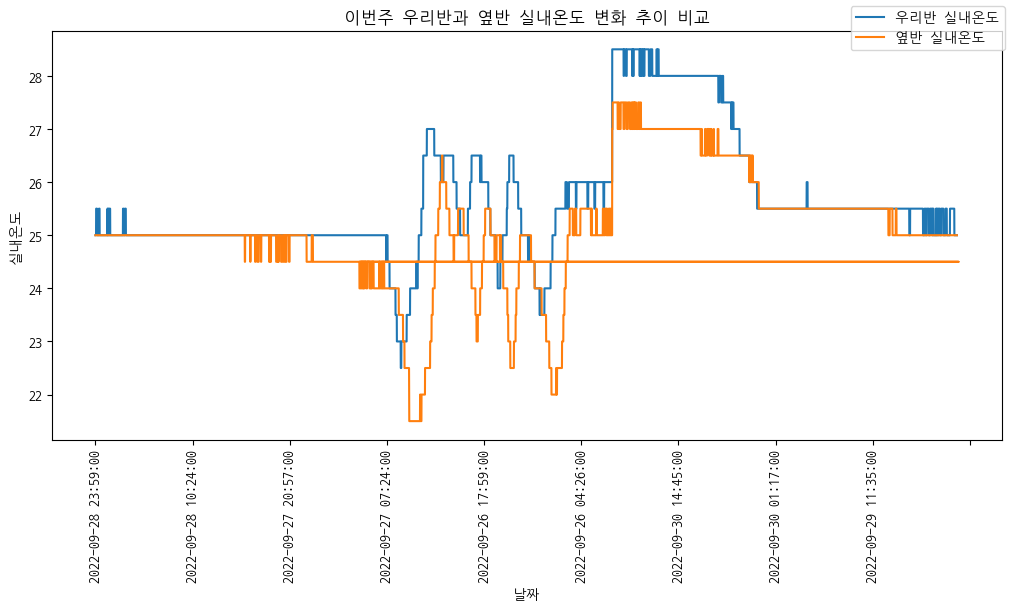

Time elapsed(s): 3.876784324645996
Time elapsed(s): 1.5038282871246338


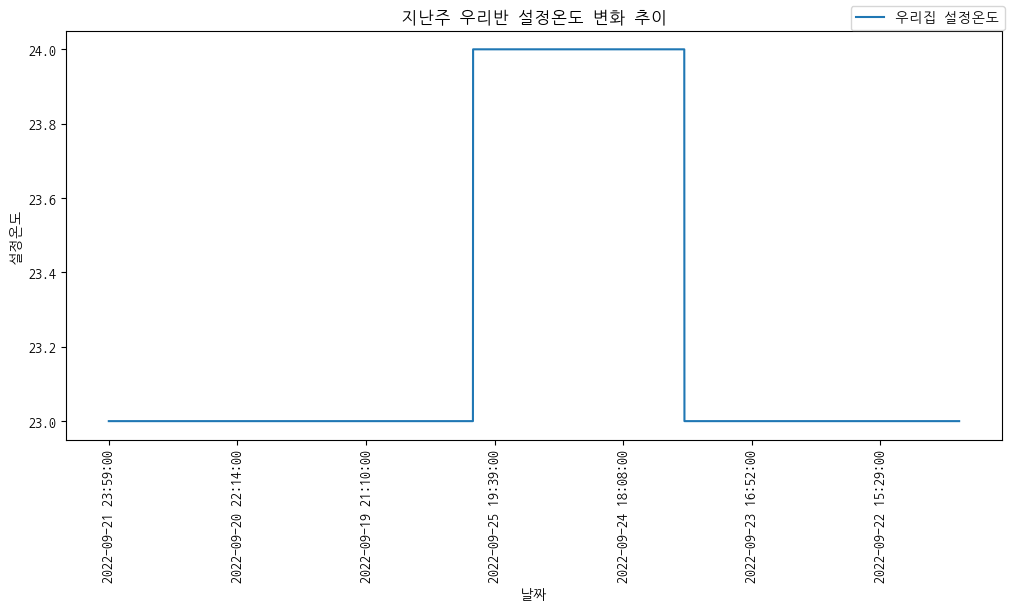

Time elapsed(s): 1.752936840057373


KeyboardInterrupt: 

In [46]:
time_elapseds = []
with open("response_result_pass.txt", "w") as f:
    for data in datas:
        start_time = time.time()
        input, tags, scenario, result = data["Input"], data["Tags"], data["Scenario"], data["Result"]
        
        tags = tags['Style']
        # skip_tags = ["Graph", "Reason"]

        # skip = False
        # for skip_tag in skip_tags:
        #     print(skip_tag, tags)
        #     if skip_tag in tags:
        #         skip = True
        #         break
        
        # if skip:
        #     continue

        pass_tags = ["Graph"]

        pass_ = False
        for tag in skip_tags:
            if tag in tags:
                pass_ = True
                break
        
        if not pass_:
            continue
        
        print("====================================================", file=f)
        metadata = metadatas[scenario]

        variables = {}
        for instruction in result:
            i_type = instruction["type"]
            if i_type == "o":
                for k, v in instruction["returns"].items():
                    type_, value = v
                    # print(k, type_, value)
                    if type_ == "pd":
                        # restore pd.DataFrame.to_dict(orient="index") or pd.Series.to_dict()
                        value = pd.DataFrame.from_dict(value, orient="index")
                    elif type_ in ["primitive"]:
                        pass
                    else:
                        raise NotImplementedError(f"Unsupported type: {k, type_, value}")
                    variables[k] = value
                variables.update()

                # print(input, variables)
            elif i_type == "g":
                args = instruction["args"]
                plot_graph(args, variables)
            elif i_type == "r":
                expectations = instruction["expectations"]
                force = instruction["force"]
                if force:
                    print("질문:", input, file=f)
                    result = expectations[0]
                else:
                    user_input = input_template.format(
                        input=input,
                        expectations=expectations,
                        result=variables,
                        metadata=metadata
                    )

                    chat = [
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": user_input}
                    ]

                    print(user_input, file=f)

                    inputs = tokenizer.apply_chat_template(
                            chat,
                        tokenize=True,
                        add_generation_prompt=True,
                        return_tensors="pt"
                    ).to(model.device)

                    outputs = model.generate(
                        input_ids=inputs,
                        max_new_tokens=3000,
                        use_cache=True,
                        pad_token_id=tokenizer.pad_token_id,
                        eos_token_id=tokenizer.eos_token_id,
                        do_sample=False  # 결정론적 생성
                    )
                    
                    # 결과 디코딩 및 파싱
                    responses = tokenizer.batch_decode(outputs, skip_special_tokens=False)[0]

                    pattern = r"<\|start_header_id\|>assistant<\|end_header_id\|>(.*?)<\|eot_id\|>"
                    match = re.search(pattern, responses, re.DOTALL)
                    result = match.group(1).strip() if match else None

                end_time = time.time()
                
                print("답변:", result, file=f)
                time_elapsed = end_time - start_time
                time_elapseds.append(time_elapsed)
                print("Time elapsed(s):", time_elapsed)
                    
    print("Average time elapsed(s):", np.mean(time_elapseds))
